In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.features.importances import FeatureImportances
import pickle
import os
from tqdm import tqdm_notebook
from pydotplus import graph_from_dot_data
from IPython.display import Image, display

In [2]:
df = pd.read_pickle('../Data Files/merged.pkl')
print(df.shape)
df.head()

(1016, 21)


category                 channelId          channelTitle  \
0    People & Blogs  UCFqanUMpCMh54RmqRFh8hZw     ProfitClicksDelux   
1  Autos & Vehicles  UCfed0SJsJPmv-TTlZfHFWpA      TeCHnical sHarma   
2    How-to & Style  UCj2zirDn1hkPKSARbARfeQw          iampauljames   
3    How-to & Style  UCRfWuSls0R7jQazuddXiPvQ           Tyler Pratt   
4    People & Blogs  UC4l9z0a-bFvZyX1HAqn270A  Sevendollarclick.com   

  classification  commentCount  \
0              f         240.0   
1              f           NaN   
2              b         242.0   
3              f           8.0   
4              f           NaN   

                                            comments  commonMal  \
0  [Well I found free $3421a money making system ...        0.0   
1                                        No comments        0.0   
2  [Great job Sir!, Paul is it hard to get approv...        0.0   
3  [Didn't work, The  real  big  money??   LOL cl...        0.0   
4                                        No comments        0.0   

  completeDomains                                        description domains  \
0             NaN  After months of searching for a constant onlin...     NaN   
1             NaN  Hello à¤¦à¥‹à¤¸à¥�à¤¤à¥‹à¤‚ ðŸ˜ŠðŸ˜Š\n\nPlease...     NaN   
2             NaN  IM Report 360 outlines exactly how you can mak...     NaN   
3             NaN  My #1 Recommendation To Earning Income Online ...     NaN   
4             NaN  Click here to start making money: \nhttp://www...     NaN   

   ...                                              links linksCount  \
0  ...  [http://www.neobux.com/?r=dirven, http://imgur...        2.0   
1  ...  [https://play.google.com/store/apps/details?id...        3.0   
2  ...                                           No links        0.0   
3  ...  [http://go.tylerpratt.com/, http://go.tylerpra...        9.0   
4  ...  [http://www.sevendollarclick.com, https://www....       12.0   

                                         linksDown linksDownCount  \
0  [[http://www.neobux.com/?r=dirven, HTTP error]]              1   
1                                               []              0   
2                                               []              0   
3                                               []              0   
4                                               []              0   

                                             linksUp redirectedDomains  \
0                        [https://imgur.com/NcIH1y8]               NaN   
1  [https://play.google.com/store/apps/details?id...               NaN   
2                                                 []               NaN   
3  [https://go.tylerpratt.com/, https://go.tylerp...               NaN   
4  [https://sevendollarclick.com/, https://www.yo...               NaN   

                                                tags  \
0  [Money (TV Episode), How-to (Media Genre), Bus...   
1  [Earn Free Money, Make Money with Android App,...   
2      [Make Money Online, Pay Per Click, Affiliate]   
3  [make money online, tyler pratt, tylerpratt, e...   
4  [how to make money, how to make money online, ...   

                                               title  \
0  How to make money online just by clicking ads ...   
1  Earn Money by Clicking On  own Android App. Ea...   
2  Make Money Online With No Website Using Pay Pe...   
3  Easy Side Online Job Clicking Ads and Making M...   
4  Earn Money By Clicking Ads | Earn $7 Per Click...   

                                       videoId viewCount  
0  https://www.youtube.com/watch?v=dFotOUq0Z4E  296630.0  
1  https://www.youtube.com/watch?v=nz7Fs7YPCIM  169662.0  
2  https://www.youtube.com/watch?v=JYVTcpIXi_4  206170.0  
3  https://www.youtube.com/watch?v=H1KmFXp2Ymg    7104.0  
4  https://www.youtube.com/watch?v=WBHBZMeywY4   53451.0  

[5 rows x 21 columns]

In [4]:
df.columns

Index(['category', 'channelId', 'channelTitle', 'classification',
       'commentCount', 'comments', 'commonMal', 'completeDomains',
       'description', 'domains', 'linkContent', 'links', 'linksCount',
       'linksDown', 'linksDownCount', 'linksUp', 'redirectedDomains', 'tags',
       'title', 'videoId', 'viewCount'],
      dtype='object')

### extract feature columns

In [3]:
data = df[['classification','description','title','tags']]

data['feature'] = (data['description'] + ' ' 
                   + data['title'] + ' ' 
                   + data['tags'].apply(lambda l: ' '.join(l)))
data.drop(['description','title','tags'], 
          axis=1, inplace=True)

data['feature'] = (data['feature']
                   .str.encode('ascii', 'ignore')
                   .str.decode('utf-8')
                   .astype(str))
data.head()

C:\Users\ruote\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\ruote\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\ruote\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[

classification                                            feature
0              f  After months of searching for a constant onlin...
1              f  Hello  \n\nPlease like, share, subscribe \n\nT...
2              b  IM Report 360 outlines exactly how you can mak...
3              f  My #1 Recommendation To Earning Income Online ...
4              f  Click here to start making money: \nhttp://www...

### preprocessing

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
en_stop = get_stop_words('en')

In [5]:
data['feature'] = (data['feature'].str
                   .lower()
                   .replace(r'\d+', '', regex=True)
                   .apply(lambda s: tokenizer.tokenize(s))
                   .apply(lambda toks: [j for j in toks if not j in en_stop])
                   .apply(lambda toks: [p_stemmer.stem(j) for j in toks])
                   .apply(lambda toks: ' '.join(toks))
                   .replace(r'www|http|https|com', '', regex=True)
                  )

C:\Users\ruote\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
data.head()

classification                                            feature
0              f  month search constant onlin earn money found o...
1              f  hello pleas like share subscrib thank subscrib...
2              b  im report outlin exactli can make money onlin ...
3              f  remend earn in onlin click  go tylerpratt  loo...
4              f  click start make money   sevendollarclick  ___...

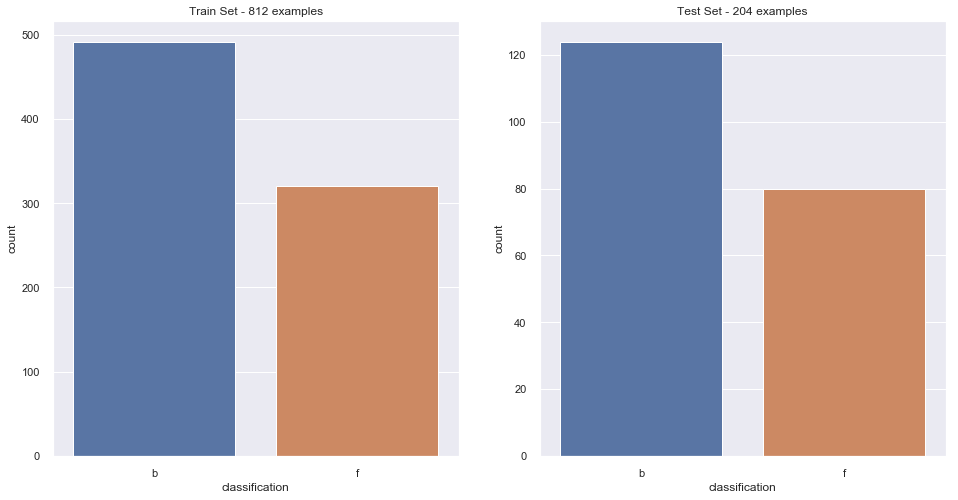

In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=2)

# Plot to ensure class distribution is intact after splitting
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
sns.countplot(data=train, x='classification', ax=axes[0]);
axes[0].set_title(f'Train Set - {train.shape[0]} examples');
sns.countplot(data=test, x='classification', ax=axes[1]);
axes[1].set_title(f'Test Set - {test.shape[0]} examples');

In [11]:
enc = CountVectorizer()
train_x = enc.fit_transform(train['feature'])
test_x = enc.transform(test['feature'])

In [12]:
len(enc.vocabulary_)

11324

### the model

In [29]:
clf = RandomForestClassifier(n_estimators=10_000, criterion='gini', random_state=2, n_jobs=-1)
clf.fit(train_x, train['classification'].cat.codes)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [30]:
# train accuracy
clf.score(train_x, train['classification'].cat.codes)

1.0

In [31]:
preds = clf.predict(test_x)

In [32]:
# test accuracy
clf.score(test_x, test['classification'].cat.codes)

0.9313725490196079

In [33]:
print(classification_report(test['classification'].cat.codes, preds,
                            target_names=test['classification'].cat.categories))

              precision    recall  f1-score   support

           b       0.97      0.92      0.94       124
           f       0.88      0.95      0.92        80

   micro avg       0.93      0.93      0.93       204
   macro avg       0.92      0.93      0.93       204
weighted avg       0.93      0.93      0.93       204



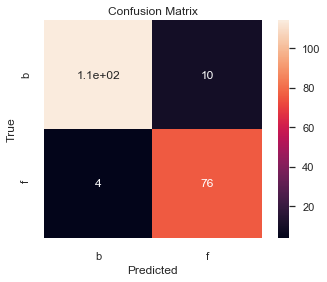

In [34]:
cmat = confusion_matrix(test['classification'].cat.codes, preds)
ax = sns.heatmap(cmat, annot=True, square=True, 
                 xticklabels=test['classification'].cat.categories,
                 yticklabels=test['classification'].cat.categories);
ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='True');

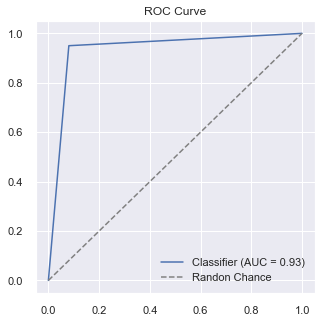

In [35]:
fpr, tpr, _ = roc_curve(test['classification'].cat.codes, preds)
auc = roc_auc_score(test['classification'].cat.codes, preds)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(fpr, tpr, label=f'Classifier (AUC = {auc:.2f})')
ax.plot([0,1], [0,1], linestyle='dashed', color='grey', label='Randon Chance')
ax.set_title('ROC Curve')
ax.legend();

C:\Users\ruote\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


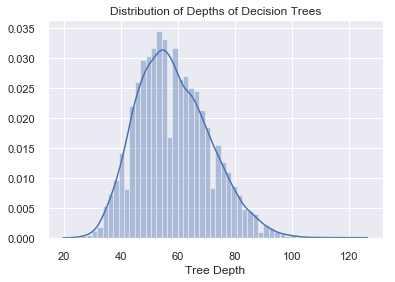

In [38]:
depths = [t.tree_.max_depth for t in clf.estimators_]
ax = sns.distplot(depths);
ax.set(title='Distribution of Depths of Decision Trees',
       xlabel='Tree Depth');

In [39]:
scores = []

for t in tqdm_notebook(clf.estimators_):
    score = t.score(test_x, test['classification'].cat.codes)
    scores.append(score)

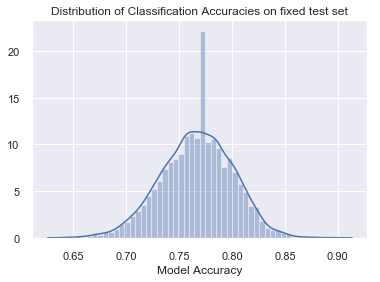

In [40]:
ax = sns.distplot(scores);
ax.set(title='Distribution of Classification Accuracies on fixed test set',
       xlabel='Model Accuracy');

### hyperparameters

In [6]:
enc = CountVectorizer()
data_x = enc.fit_transform(data['feature'])

In [13]:
# k_fold = 5
cv_obj = KFold(n_splits=5, shuffle=False, random_state=42)

In [21]:
# excercise patience with this
train_sz, train_score, test_score = learning_curve(RandomForestClassifier(n_estimators=10_000, criterion='gini', random_state=2), 
                                                   data_x, data['classification'].cat.codes, 
                                                   cv=cv_obj, verbose=2, random_state=2, n_jobs=-1)

[learning_curve] Training set sizes: [ 81 263 446 629 812]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  2.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.7min finished


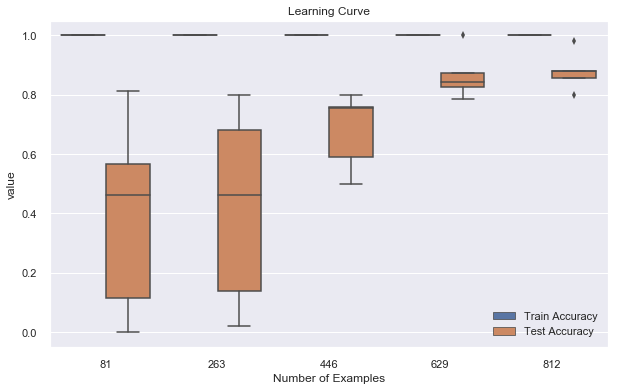

In [48]:
results = pd.DataFrame({
    'Number of Examples': np.tile(train_sz, (k_fold,1)).T.flatten(),
    'Train Accuracy': train_score.flatten(),
    'Test Accuracy': test_score.flatten(),
})
results = results.melt(id_vars='Number of Examples', value_vars=['Train Accuracy','Test Accuracy'])

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=results, 
            x="Number of Examples", y='value', hue="variable", ax=ax)
ax.set_title('Learning Curve');
ax.legend();

In [14]:
params = {
    'n_estimators': [100,500,1000,5000,10_000,15_000],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,4,6,8],
    
}

In [15]:
# takes about half an hour
cv_clf = GridSearchCV(RandomForestClassifier(), param_grid=params, refit=True, 
                      n_jobs=-1, iid=False, cv=cv_obj, 
                      return_train_score =True, verbose=2)
# cv_clf.fit(train_x, train['classification'].cat.codes)
cv_clf.fit(data_x, data['classification'].cat.codes)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 42.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000, 5000, 10000, 15000], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [16]:
# Save grid search results
with open(f'results/RF_grid_5Kfold_results.pkl', 'wb') as f:
    pickle.dump(cv_clf, f)
with open(f'results/RF_grid_5Kfold_encoder.pkl', 'wb') as f:
    pickle.dump(enc, f)

In [7]:
# Load grid search results
with open(f'results/RF_grid_5Kfold_results.pkl', 'rb') as f:
    cv_clf = pickle.load(f)
with open(f'results/RF_grid_5Kfold_encoder.pkl', 'rb') as f:
    enc = pickle.load(f)

In [8]:
cv_clf.best_params_

{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 500}

In [9]:
cv_clf.best_score_

0.8907997681831354

In [15]:
cv_results = pd.DataFrame(cv_clf.cv_results_)

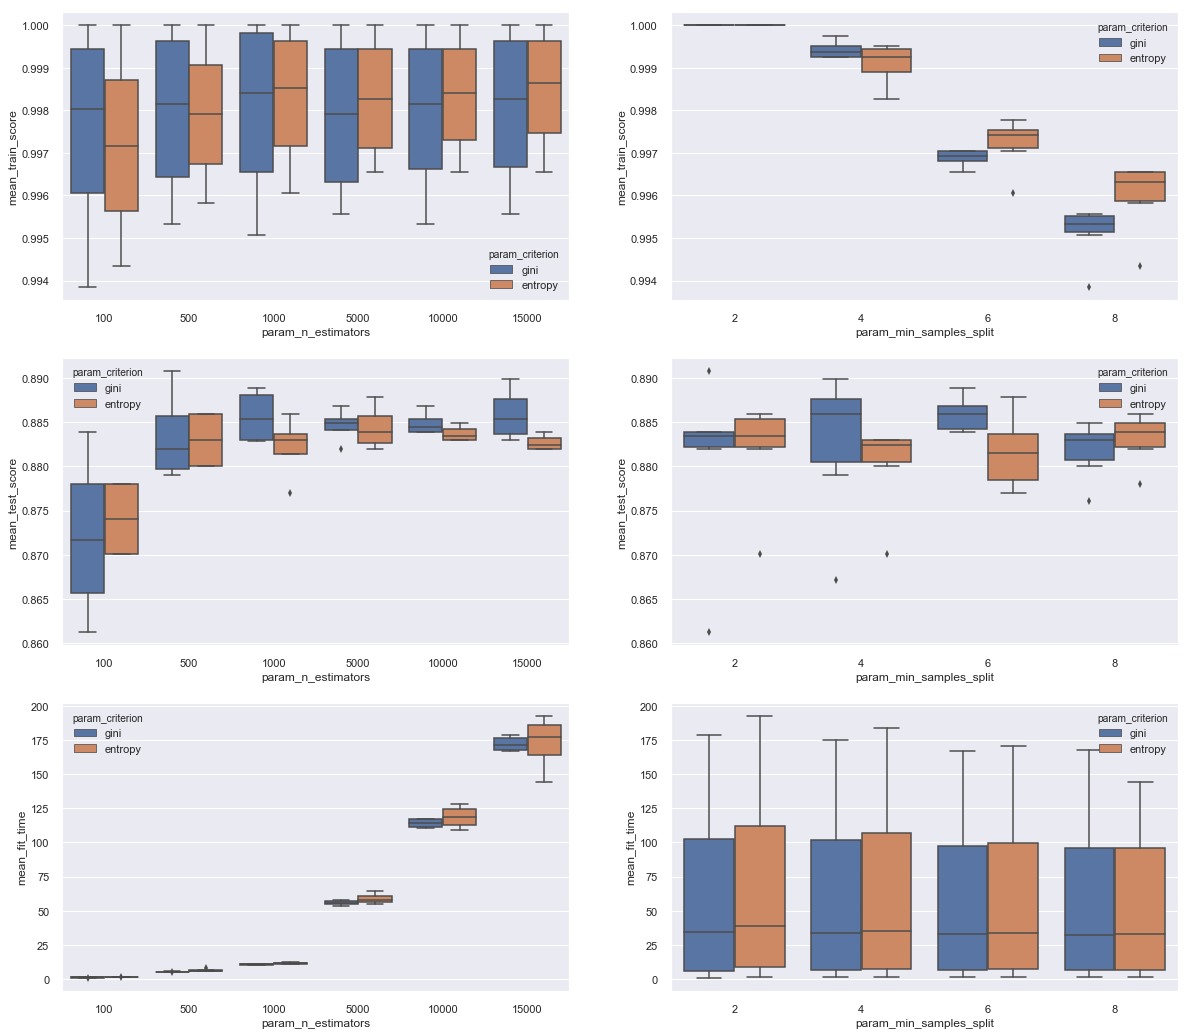

In [57]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,18))
axes = axes.flatten()

sns.boxplot(data=cv_results, x="param_n_estimators", y="mean_train_score", 
            hue='param_criterion', ax=axes[0])
sns.boxplot(data=cv_results, x="param_min_samples_split", y="mean_train_score", 
            hue='param_criterion', ax=axes[1])

sns.boxplot(data=cv_results, x="param_n_estimators", y="mean_test_score", 
            hue='param_criterion', ax=axes[2])
sns.boxplot(data=cv_results, x="param_min_samples_split", y="mean_test_score", 
            hue='param_criterion', ax=axes[3])

sns.boxplot(data=cv_results, x="param_n_estimators", y="mean_fit_time", 
            hue='param_criterion', ax=axes[4])
sns.boxplot(data=cv_results, x="param_min_samples_split", y="mean_fit_time", 
            hue='param_criterion', ax=axes[5]);

### model diagnostics

In [10]:
best_clf = cv_clf.best_estimator_

In [19]:
imp = pd.DataFrame({'imp': best_clf.feature_importances_*100}, 
                   index=enc.get_feature_names())
imp.sort_values('imp', ascending=False, inplace=True)

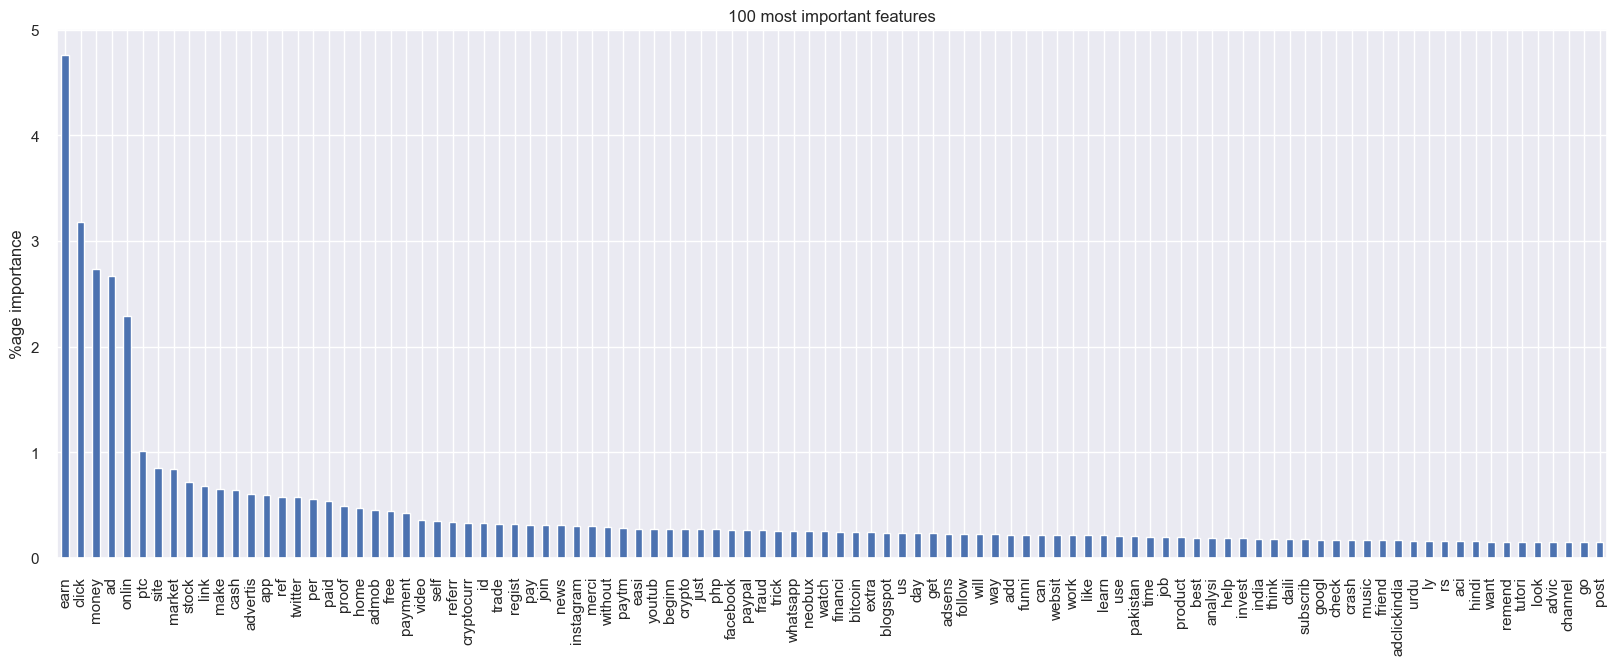

In [20]:
fig, ax = plt.subplots(figsize=(20,7), dpi=100)
top_n = 100
imp.iloc[:top_n].plot(kind='bar', ax=ax);
ax.set_title(f'{top_n} most important features')
ax.set_ylabel('%age importance')
ax.legend().remove()

C:\Users\ruote\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


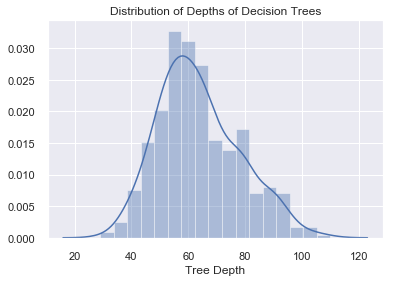

In [78]:
depths = [clf.tree_.max_depth for clf in best_clf.estimators_]
ax = sns.distplot(depths);
ax.set(title='Distribution of Depths of Decision Trees',
       xlabel='Tree Depth');

In [26]:
_, dataX_test, _, data_test = train_test_split(data_x, data, test_size=0.2, random_state=2)

In [27]:
scores = []

for clf in tqdm_notebook(best_clf.estimators_):
    score = clf.score(dataX_test, data_test['classification'].cat.codes)
    scores.append(score)

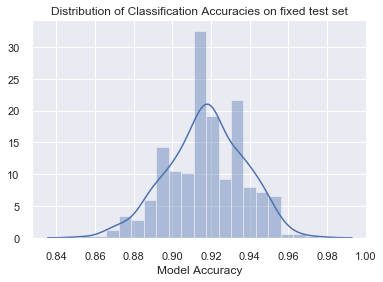

In [28]:
ax = sns.distplot(scores);
ax.set(title='Distribution of Classification Accuracies on fixed test set',
       xlabel='Model Accuracy');

In [47]:
scores_idx = np.argsort(scores)

In [48]:
best_tree = best_clf.estimators_[scores_idx[-1]]
median_tree = best_clf.estimators_[scores_idx[len(scores_idx)//2]]
worst_tree = best_clf.estimators_[scores_idx[0]]

In [70]:
dot_data = export_graphviz(worst_tree, 
                feature_names=enc.get_feature_names(),
                class_names=data['classification'].cat.categories,
                rounded=True, proportion=False, 
                precision=2, filled=True)

In [71]:
graph = graph_from_dot_data(dot_data)  
Image(graph.create_png())